First figure of the manuscript, showing "broadband" timescales. 
- Brain maps of timescales across wake and sleep stages.
- Overall timescales changes in wake and sleep across all brain areas.
- Correlation sizes of timescales with T1w/T2w score.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore, bootstrap, ttest_rel
import matplotlib.pyplot as plt
import mne
import nibabel as nib

from mnitimescales import utils
from mnitimescales import plots

plots._set_font_params()

Imports and definitions:

In [3]:
stages = ["W", "N3", "R"]
stage_colors = {"W": "red", "N2": "cyan", "N3": "purple", "R": "green"}
title_dict = {"W": "Wake", "N2": "NREM2", "N3": "NREM3", "R": "REM"}
corr_type = "pearson"

# Paths
data_path = Path("F:\\MNIOpen")
tau_path = data_path.joinpath("Results", "timescales_gamma")
fig_path = data_path.joinpath("Figures", "Fig_gamma")
fig_path.mkdir(exist_ok=True, parents=True)
df_timescales_stages = {
    stage: pd.read_csv(tau_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

# Parcellation
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot


### A) Average ACFs across wake and sleep 

Comparison of average ACF curves across wake and sleep stages.

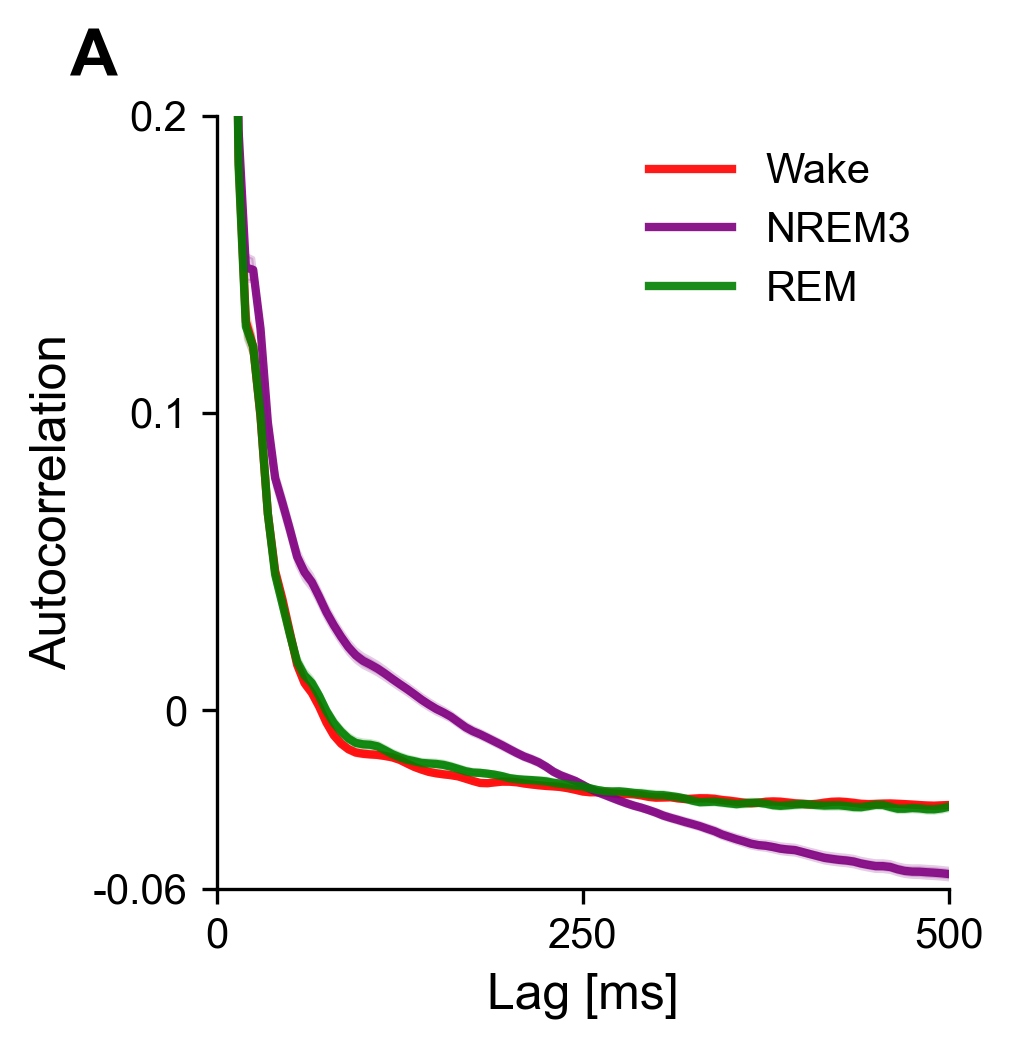

In [28]:
# Set up the figure
fig, ax = plt.subplots(figsize=plots._get_figsize_inches((8., 8.5)), dpi=300)

# Find patients subfolders
pats = [pat.stem for pat in tau_path.joinpath("Pats").glob("*") if pat.is_dir()]

# Loop through stages
for stage in stages:

    # Store ACF for all patients
    acf_pats_stage = []
    lags = None

    # Loop through patients
    for pat in pats:
        pat_dir = tau_path.joinpath("Pats").joinpath(pat)
        # Load ACF
        try:
            with open(
                pat_dir.joinpath("ACF/" + pat + "_" + stage.lower() + ".pkl"),
                "rb",
            ) as f:
                acf_pat_stage = pickle.load(f)
        except FileNotFoundError:
            continue

        # Append channels
        acf_pats_stage.append(acf_pat_stage["acf"].mean(axis=0).mean(axis=0))
        if lags is None:
            lags = acf_pat_stage["lags"]

    # Average across patients
    N_pats = len(acf_pats_stage)
    acf_pats_stage = np.stack(acf_pats_stage)
    acf_stage_avg = acf_pats_stage.mean(axis=0)
    acf_stage_se = acf_pats_stage.std(axis=0) / np.sqrt(N_pats)

    # Figure ACF
    ax.plot(
        lags * 1000,
        acf_stage_avg,
        c=stage_colors[stage],
        label=title_dict[stage],
        lw=2,
        alpha=0.9,
    )
    ax.fill_between(
        lags * 1000,
        acf_stage_avg - acf_stage_se,
        acf_stage_avg + acf_stage_se,
        color=stage_colors[stage],
        alpha=0.2,
    )
# Plot parameters
ax.set_xlim(0, 500)
ax.set_xticks([0, 250, 500], labels=[0, 250, 500], fontsize=plots.fsize.TICK_SIZE)
ax.set_xlabel("Lag [ms]", fontsize=plots.fsize.LABEL_SIZE)
ax.set_ylim(-0.06, 0.2)
ax.set_yticks([-0.06, 0, 0.1, 0.2], labels=[-0.06, 0, 0.1, 0.2], fontsize=plots.fsize.TICK_SIZE)
ax.set_ylabel("Autocorrelation", fontsize=plots.fsize.LABEL_SIZE)
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False, fontsize=plots.fsize.TICK_SIZE, loc="upper right")

# Annotate panel
ax.text(-0.2, 1.05, "A", transform=ax.transAxes, size=16, weight='bold')

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"ACF_average.svg"))

plt.show()

### B) Average increase of tau during sleep

Slope plot with averaged difference of timescales between wake and sleep stages across all areas of the parcellation.

diff W - N3 : 31.26772856846066 ci [28.88190902205586, 33.791065931881285] pval: 4.1005414621929593e-60
diff W - R : 1.8694043330649117 ci [0.9427720316510333, 3.1081257423175743] pval: 0.0008861941132440857


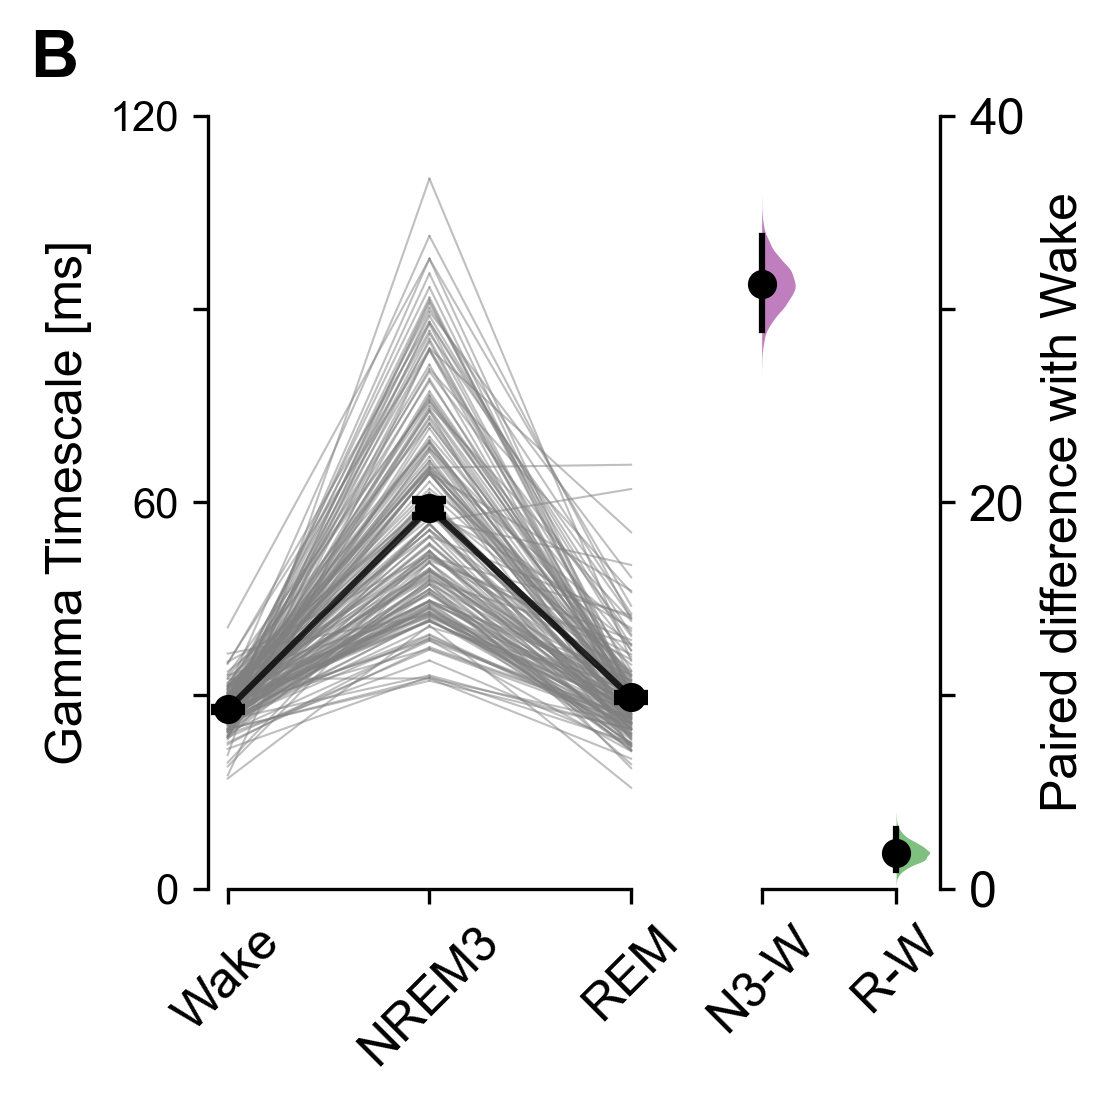

In [6]:
# Prepare dataframe for plotting
df_plot = deepcopy(df_timescales_stages)
for stage in stages:
    df_plot[stage]["stage"] = stage
df_plot = pd.concat(df_plot.values())
df_plot.rename(columns={"0": "tau"}, inplace=True)
df_plot = df_plot.pivot(columns="stage", values="tau")
df_plot = df_plot[stages]

# Figure
fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((8., 8.5)),
    width_ratios=[2, 1],
    dpi=300,
)

# Slope plot
axs[0] = plots.slope_plot(axs[0], df_plot)
# Plot parameters
axs[0].set_ylabel("Gamma Timescale [ms]", fontsize=plots.fsize.LABEL_SIZE)
axs[0].set_ylim(0, 120)
axs[0].set_yticks([0, 30, 60, 90, 120], labels=[0, "", 60, "", 120], fontsize=plots.fsize.TICK_SIZE)
axs[0].set_xticks(
    range(len(stages)),
    [title_dict[stage] for stage in stages],
    rotation=45,
    ha="center",
    fontsize=plots.fsize.LABEL_SIZE,
)
plots._format_spines(axs[0], s_bounds={"bottom": (0, 2)})


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)


# Plot differences
for i, stage in enumerate(stages[1:]):
    avg = avg_diff(df_plot[stage], df_plot["W"])
    pval = ttest_rel(df_plot[stage], df_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    res_boot = bootstrap(
        (df_plot[stage], df_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )
    print("diff W -", stage, ":", avg, "ci", list(res_boot.confidence_interval), "pval:", pval)
    axs[1] = plots.half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=stage_colors[stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=plots.fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylim(0, 40)
axs[1].set_yticks(
    [0, 10, 20, 30, 40],
    labels=[0, "", 20, "", 40],
    fontsize=plots.fsize.LABEL_SIZE,
)
axs[1].set_xticks(
    range(len(stages) - 1),
    [stage + "-W" for stage in stages[1:]],
    rotation=45,
    fontsize=plots.fsize.LABEL_SIZE,
)
plots._format_spines(axs[1], s_inv=["top", "left"], s_bounds={"bottom": (0, 1)})

# Annotate panel
axs[0].text(-0.4, 1.05, "B", transform=axs[0].transAxes, size=16, weight='bold')

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"tau_change_stages.svg"))
plt.show()

% channels increasing in sleep:

In [11]:
(df_timescales_stages["R"] > df_timescales_stages["N3"]).sum()

0    2
dtype: int64

In [12]:
df_timescales_stages["R"][df_timescales_stages["R"] > df_timescales_stages["N3"]].dropna()

,0
V6,65.811304
V7,62.036679


### C) Plot of parcellated brain areas

Plot absolute values and differences between stages of timescales in the HCP_MMP parcellation.

In [7]:
minmax_stages = {"W": (20, 35), "N2": (30, 50), "N3": (35, 95), "R": (20, 50)}

# Loop through stages
for stage in stages:

    fig, ax = plots.plot_parcellated_metric(
        df_timescales_stages[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="Timescale [ms]",
        cbar_format="0f",
    )

    if stage == "W":
        # Annotate panel
        ax.text(-0.2, 1.05, "C", transform=ax.transAxes, size=16, weight='bold')

    fig.savefig(
        fig_path.joinpath(f"tau_parc_{stage}.svg"),
        format="svg",
        transparent=True,
    )
    plt.close(fig)

Using pyvistaqt 3d backend.



c:\Users\ricca\anaconda3\envs\mni_analysis\lib\site-packages\pyvista\plotting\plotting\__init__.py:23: PyVistaDeprecationWarning: The `pyvista.plotting.plotting` module has been deprecated. `_ALL_PLOTTERS` is now imported as: `from pyvista.plotting import _ALL_PLOTTERS`.
  warnings.warn(


Maps of differences

In [9]:
# Differences
df_plot_W_N3 = df_timescales_stages["N3"] - df_timescales_stages["W"]  # [20, 85]
df_plot_W_R = df_timescales_stages["R"] - df_timescales_stages["W"]  # [-5, 30]

# NREM3 figure
fig, ax = plots.plot_parcellated_metric(
    df_plot_W_N3.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(10, 65),
    zero_center=False,
    title="NREM3 - Wake",
    cmap="Reds",
    label="Timescale difference [ms]",
    cbar_format="0f",
)
fig.savefig(fig_path.joinpath(f"tau_parc_N3-W.svg"), format="svg", transparent=True)
plt.close(fig)


# REM figure
fig, ax = plots.plot_parcellated_metric(
    df_plot_W_R.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(-10, 20),
    zero_center=False,
    title="REM - Wake",
    cmap="Reds",
    label="Timescale difference [ms]",
    cbar_format="0f",
)
fig.savefig(fig_path.joinpath(f"tau_parc_R-W.svg"), format="svg", transparent=True)
plt.close(fig)

### D) Correlation with structure

Load T1w/T2w data and the centroids coordinates of the parcellation (for spin permutation):

In [14]:
df_struct = pd.read_csv(data_path.joinpath("Data", "Raw", "df_structural_avg.csv"), index_col=0)
map_coords = pd.read_csv(data_path.joinpath("Data", "Parcellation", "mmp_centroids_coords.csv"), index_col=0)

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


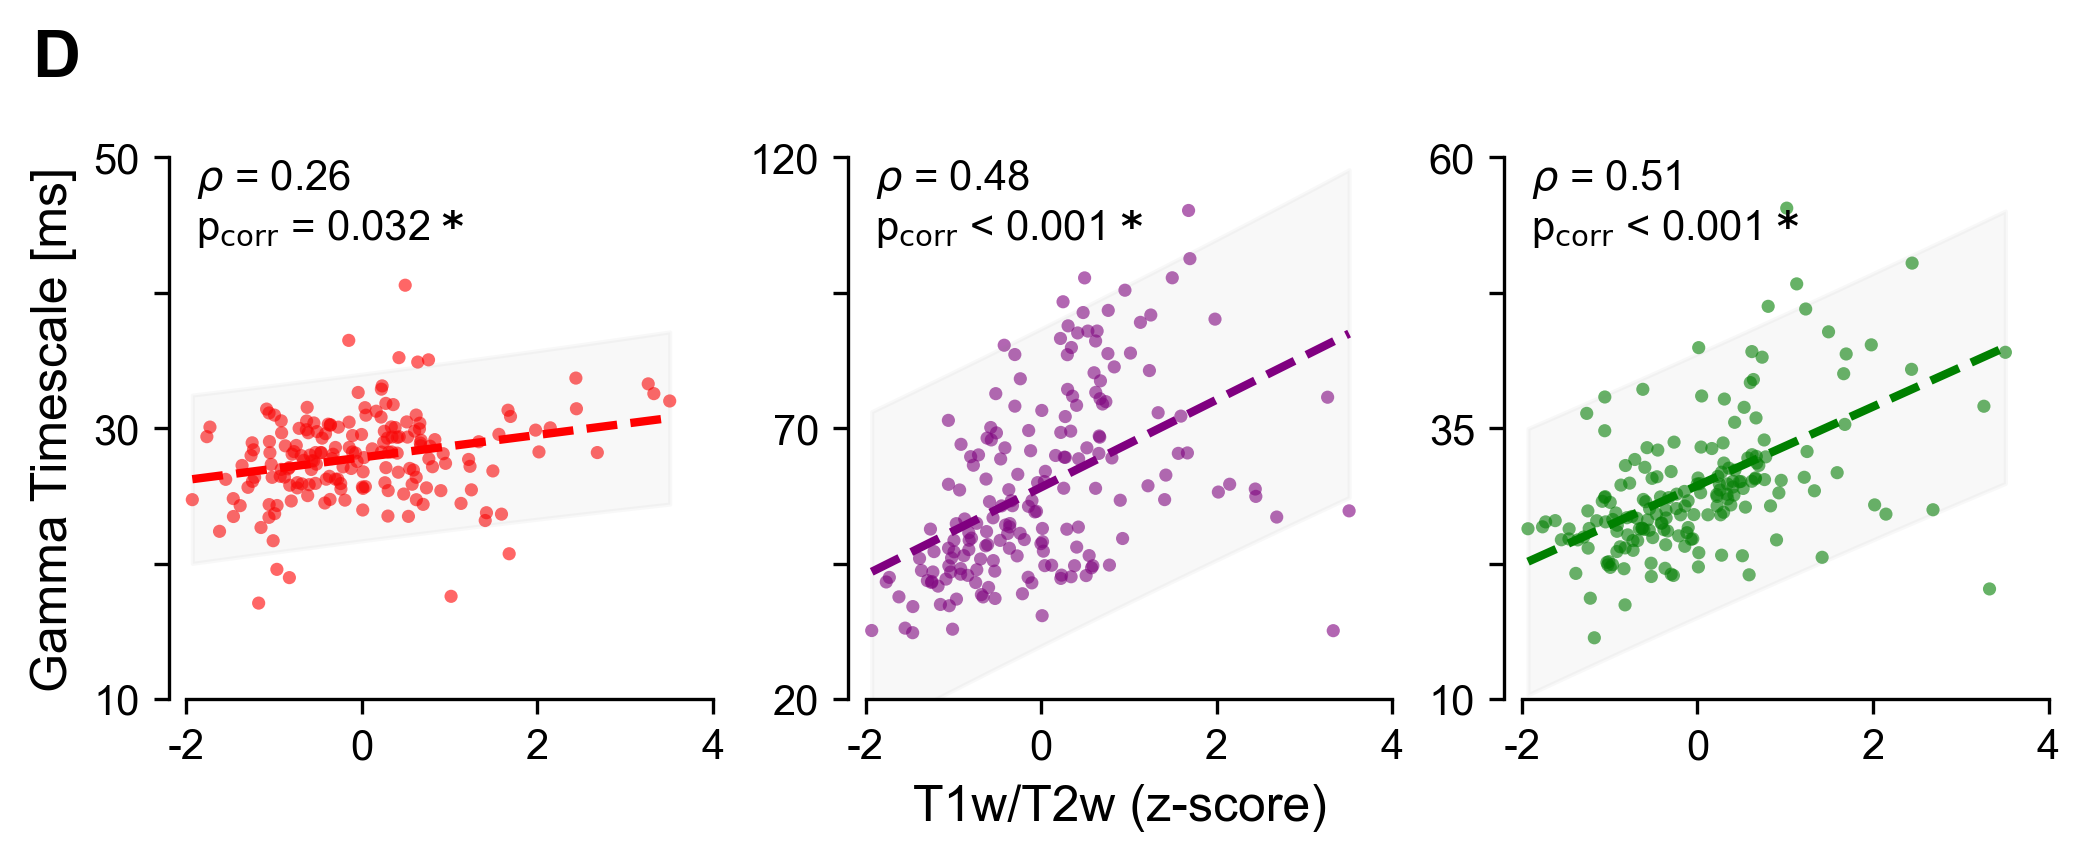

In [6]:
xlabel = "T1w/T2w (z-score)"
ylabel = "Gamma Timescale [ms]"
xlims = (-2.2, 4)
xticks = [-2, 0, 2, 4]
xtick_labels = [-2, 0, 2, 4]
ylims_stages = {"W": (10, 50), "N2": (25, 65), "N3": (20, 120), "R": (10, 60)}
yticks = (
    np.arange(10, 51, 10),
    np.arange(20, 121, 25),
    np.arange(10, 61, 12.5)
    )
ytick_labels = (
    [10, "", 30, "", 50],
    [20, "", 70, "", 120],
    [10, "", 35, "", 60]
    )

fig, axs = plt.subplots(
    1, len(stages), figsize=plots._get_figsize_inches((17.4, 7)), dpi=300, layout="constrained"
)

rhos, p_corrs, rhos_boot = {}, {}, {}

for i, stage in enumerate(stages):
    # Import dataframe
    df_metric = df_plot[stage].copy()

    # Get data
    x = zscore(df_struct["T1T2"], ddof=1).to_numpy()
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
    rhos[stage] = rho
    p_corrs[stage] = p_corr
    rhos_boot[stage] = rho_boot

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=10,
        xy_annot=(0.05, 0.85),
        color=stage_colors[stage],
        xlabel="",
        ylabel="",
        xlims=xlims,
        ylims=ylims_stages[stage],
    )
    
    # Set ticks
    axs[i].set_xticks(xticks, labels=xtick_labels, fontsize=plots.fsize.TICK_SIZE)
    axs[i].set_yticks(yticks[i], labels=ytick_labels[i], fontsize=plots.fsize.TICK_SIZE)
    plots._format_spines(axs[i], s_bounds={"bottom": (-2, 4), "left": ylims_stages[stage]})

# Plot customization
axs[0].set_ylabel(ylabel, fontsize=plots.fsize.LABEL_SIZE)
axs[1].set_xlabel(xlabel, fontsize=plots.fsize.LABEL_SIZE)

# Annotate panel
axs[0].text(-0.25, 1.15, "D", transform=axs[0].transAxes, size=16, weight='bold')

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"tau_corr_struct.svg"))

plt.show()

### S0) Correlation between timescales in different stages

W N3
LinregressResult(slope=0.4837666712741739, intercept=45.642404538054215, rvalue=0.0923147637298561, pvalue=0.21774829771358956, stderr=0.3911076570890877, intercept_stderr=10.962211381460147)


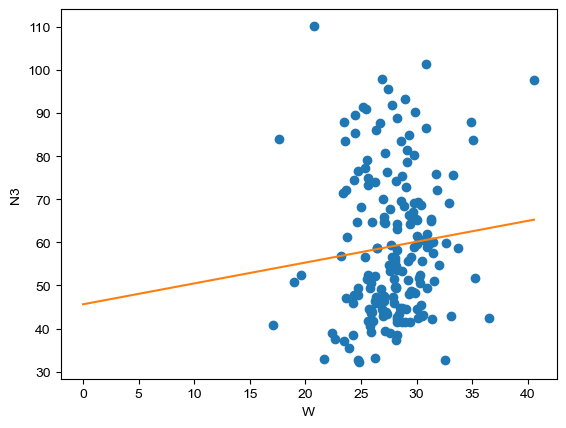

W R
LinregressResult(slope=0.2950969855483444, intercept=21.497645786870414, rvalue=0.1328761048544087, pvalue=0.07537204338112141, stderr=0.16498317940569704, intercept_stderr=4.624252310710065)


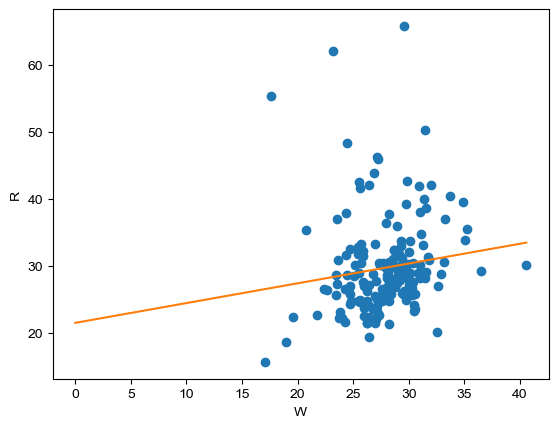

N3 R
LinregressResult(slope=0.19118005713442465, intercept=18.41347851697038, rvalue=0.45111730258378724, pvalue=2.0799417901454236e-10, stderr=0.028348764209225646, intercept_stderr=1.7419246516387317)


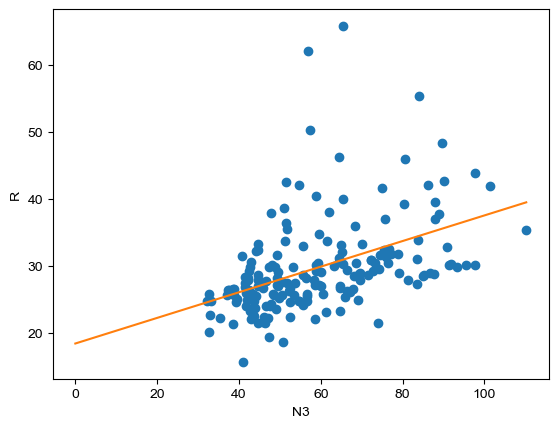

In [4]:
from scipy import stats

for s1, s2 in zip(["W", "W", "N3"], ["N3", "R", "R"]):
    print(s1, s2)
    x = df_timescales_stages[s1].to_numpy().squeeze()
    y = df_timescales_stages[s2].to_numpy().squeeze()
    plt.plot(x, y, "o")
    res = stats.linregress(x, y)
    print(res)
    x_plot = np.linspace(0, x.max(), 100)
    plt.plot(x_plot, res.intercept + res.slope * x_plot)
    plt.xlabel(s1)
    plt.ylabel(s2)
    plt.show()

### S1) Correlation with broadband and alpha-beta timescales

W
Generating 1000 permutations...


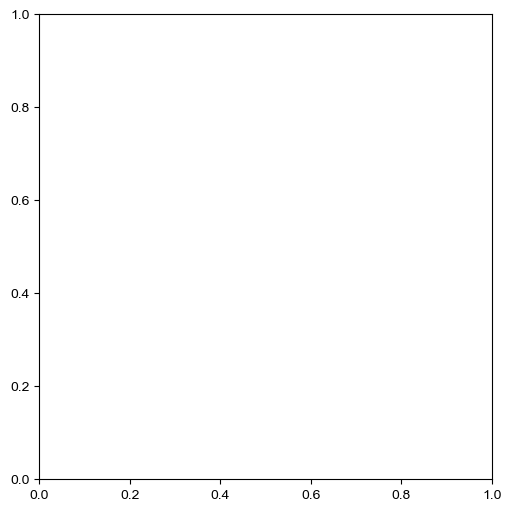

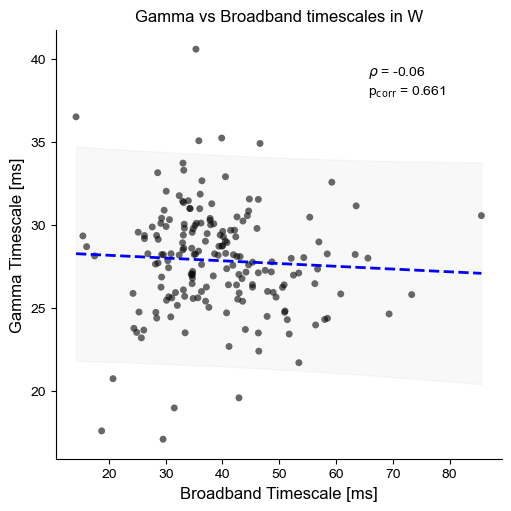

N3
Generating 1000 permutations...


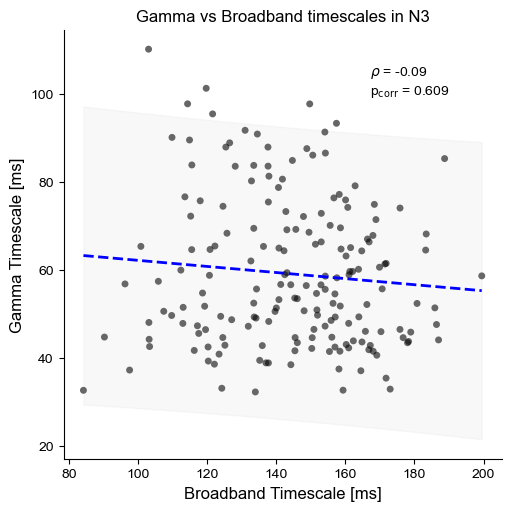

R
Generating 1000 permutations...


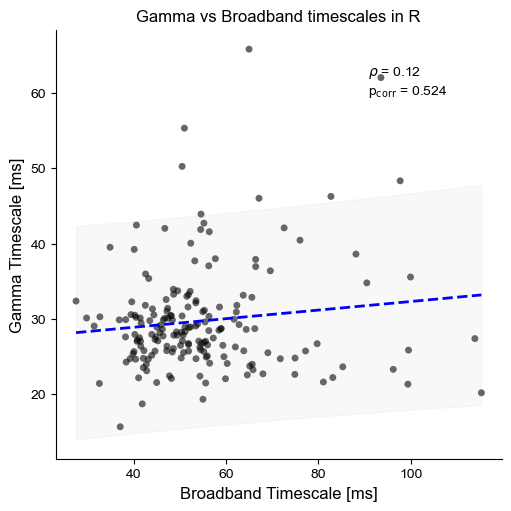

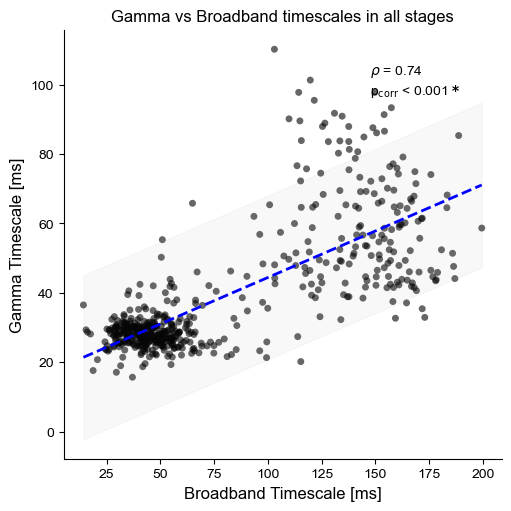

In [18]:
df_timescales_broadband = {
    stage: pd.read_csv(data_path.joinpath("Results", "timescales_broadband", f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

x_tot = []
y_tot = []
for stage in stages:
    print(stage)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
    x = df_timescales_broadband[stage].loc[df_timescales_stages[stage].index].to_numpy().squeeze()
    y = df_timescales_stages[stage].to_numpy().squeeze()
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    ax = plots.plot_corr(
        ax,
        x,
        y,
        rho,
        p_corr,
        color_line="b",
        figsize=(5*2.4, 5*2.4),  # 2.4 is to get inches
        markersize=25,
        title=f"Gamma vs Broadband timescales in {stage}",
        xlabel="Broadband Timescale [ms]",
        ylabel="Gamma Timescale [ms]",
    )
    x_tot += list(x)
    y_tot += list(y)
    # ax.set_xlabel("Broadband Timescale [ms]")
    # ax.set_ylabel("Gamma Timescale [ms]")

    plt.show()


fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
x_tot = np.array(x_tot)
y_tot = np.array(y_tot)
# rho, p_corr = utils.get_pcorr(x_tot, y_tot, map_coords, method="vasa", corr_type=corr_type)
from scipy.stats import linregress
res = linregress(x_tot, y_tot)
rho, p = res[2], res[3]
ax = plots.plot_corr(
    ax,
    x_tot,
    y_tot,
    rho,
    p,
    color_line="b",
    figsize=(5*2.4, 5*2.4),  # 2.4 is to get inches
    markersize=25,
    title=f"Gamma vs Broadband timescales in all stages",
    xlabel="Broadband Timescale [ms]",
    ylabel="Gamma Timescale [ms]",
)
plt.show()

W
Generating 1000 permutations...


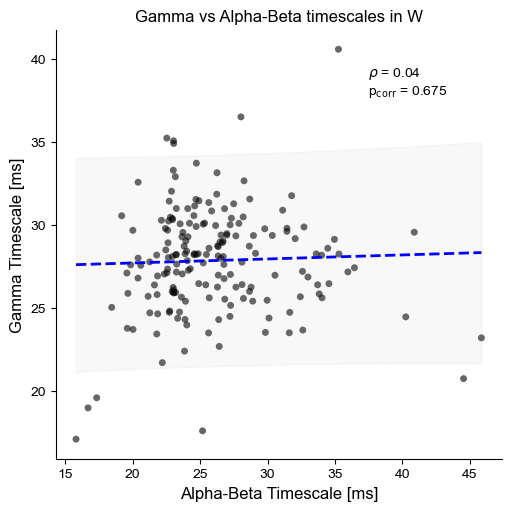

N3
Generating 1000 permutations...


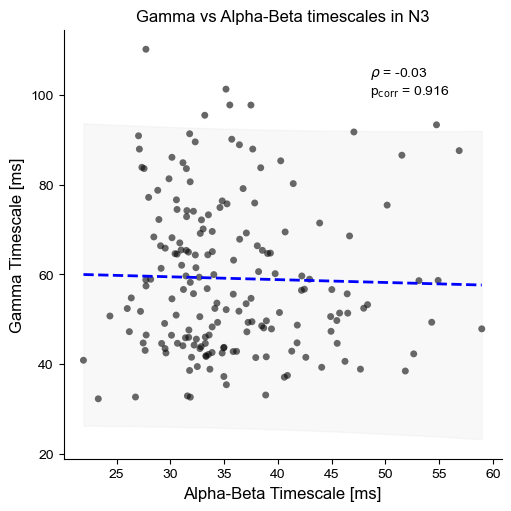

R
Generating 1000 permutations...


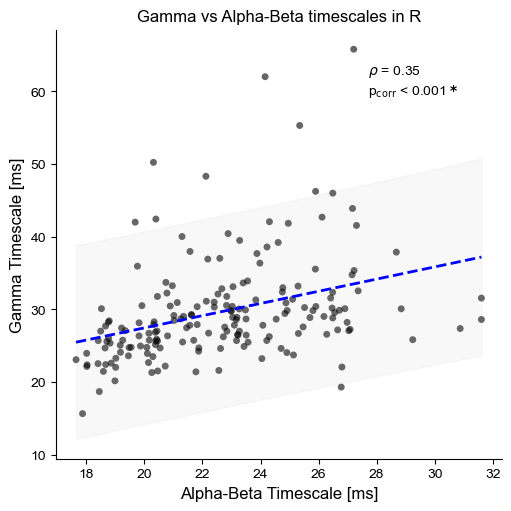

In [14]:
df_timescales_alphabeta = {
    stage: pd.read_csv(data_path.joinpath("Results", "timescales_alphabeta", f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

for stage in stages:
    print(stage)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
    x = df_timescales_alphabeta[stage].loc[df_timescales_stages[stage].index].to_numpy().squeeze()
    y = df_timescales_stages[stage].to_numpy().squeeze()
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    ax = plots.plot_corr(
        ax,
        x,
        y,
        rho,
        p_corr,
        color_line="b",
        figsize=(5*2.4, 5*2.4),  # 2.4 is to get inches
        markersize=25,
        title=f"Gamma vs Alpha-Beta timescales in {stage}",
        xlabel="Alpha-Beta Timescale [ms]",
        ylabel="Gamma Timescale [ms]",
    )
    # ax.set_xlabel("Broadband Timescale [ms]")
    # ax.set_ylabel("Gamma Timescale [ms]")

    plt.show()

### S2) Correlation with PSD exponent in the same frequency

W
Generating 1000 permutations...


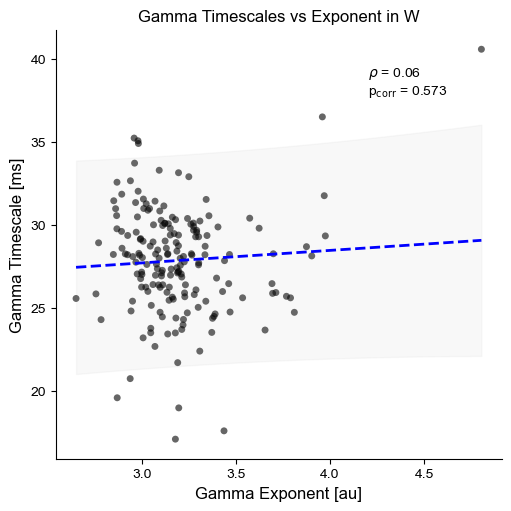

N3
Generating 1000 permutations...


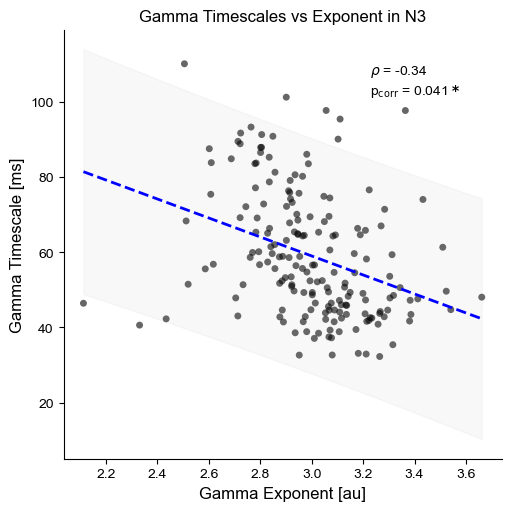

R
Generating 1000 permutations...


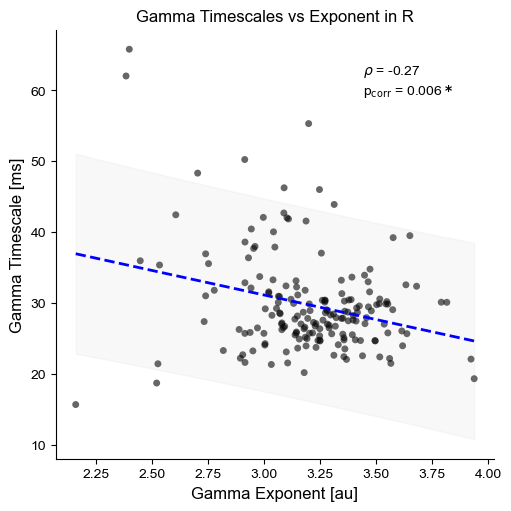

In [16]:
df_exp_gamma = {
    stage: pd.read_csv(data_path.joinpath("Results", "psd_gamma_exp", f"exp_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

for stage in stages:
    print(stage)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
    x = df_exp_gamma[stage].loc[df_timescales_stages[stage].index].to_numpy().squeeze()
    y = df_timescales_stages[stage].to_numpy().squeeze()
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    ax = plots.plot_corr(
        ax,
        x,
        y,
        rho,
        p_corr,
        color_line="b",
        figsize=(5*2.4, 5*2.4),  # 2.4 is to get inches
        markersize=25,
        title=f"Gamma Timescales vs Exponent in {stage}",
        xlabel="Gamma Exponent [au]",
        ylabel="Gamma Timescale [ms]",
    )
    # ax.set_xlabel("Broadband Timescale [ms]")
    # ax.set_ylabel("Gamma Timescale [ms]")

    plt.show()